For BPE training, Vocab, etc. it requires ~ 70GB of RAM

In [6]:
import json
import codecs
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from sklearn.model_selection import train_test_split

In [7]:
amalgama_fname = \
'/srv/hd6/data/Poem2Poem/data/ParallelEnRu/Amalgama/amalgama-reversed-song-translations.jsonl'
subtitles_fname = \
'/srv/hd6/data/Poem2Poem/data/ParallelEnRu/OpenSubtitlesv2018/en-ru-reversed.jsonl'

In [8]:
%%time

def get_amalgama_songs(dataset_fname):
    songs = []
    errors = 0
    with codecs.open(dataset_fname,
                     mode = 'r',
                     encoding = 'utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '':
                continue
            try:
                song = json.loads(line)
            except Exception as e:
                errors += 1
                print(e, '\n', line)
            songs.append([[line['texts'] \
                           for line in translation['lines'] \
                           if 'is_sub_caption' not in line \
                              and line['texts'] is not None] \
                          for translation in song['translations']])
    return songs, errors
    
songs, errors = get_amalgama_songs(amalgama_fname)
train_songs, dev_songs = train_test_split(songs, test_size = 0.1, random_state = 1)
print('len(songs)', len(songs))
print('errors', errors)
print('len(train_songs)', len(train_songs))
print('len(dev_songs)', len(dev_songs))
print(train_songs[3])

len(songs) 87208
errors 0
len(train_songs) 78487
len(dev_songs) 8721
[[["laer eb t'nac taht maerd a was I", ',йодварп ьтыб тежом ен йыроток ,нос ледив Я'], ['dnim ym ot em sekat tI', ',еинанзосдоп еом в янем келву нО'], ['enim fo maerd live siht edisni kool woN', '.нос йынчарм йом тотэ в инялгаз ьрепеТ'], ['niar eht ni gniyd uoy tfel I', ',меджод доп ьтариму ябет ливатсо Я'], ['niap gnikcuf ym leef uoy woN', '!ьлоб юутялкорп юом еж йувтсвучоП'], ['enasni ma I wonk uoY', ',немузеб я отч ,ьшеанз ыТ'], ["emas eht lla s'ti dne eht ni tuB", '?еинечанз тееми отэ еокак ,воцнок ецнок в оН'], ['laer ylno ma I maerd siht nI', ',я окьлот нелаер енс мотэ В'], ['thginot niaga em htiw ylf dna dnah ym ekaT', 'юьчон йотэ мителу авонс йавад и ,укур юом имьзоВ'], ['thgilnoom gninihs eht ni yawa raF', ',адюсто ьладв меиняис мыннул доП'], ['eid lliw ew rehtegot dna reverof era eW', '.мерму ым етсемв и адгесван етсемв ыМ'], ['enog dna daed era uoy woN', ',тен ябет ,автрем ыт сачйеС'], ["uoy rof erom on yrc

In [26]:
%time
def get_lines_from_amalgama_songs(songs):
    lines_foreign = []
    lines_russian = []
    for song in songs:
        for translation in song:
            for line_pair in translation:
                if line_pair[0] is None or line_pair[1] is None:
                    continue
                lines_foreign.append(line_pair[0])
                lines_russian.append(line_pair[1])
    return lines_foreign, lines_russian

(amalgama_train_lines_foreign,
 amalgama_train_lines_russian) = get_lines_from_amalgama_songs(train_songs)
print('len(amalgama_train_lines_foreign)', len(amalgama_train_lines_foreign))
print('len(amalgama_train_lines_russian)', len(amalgama_train_lines_russian))
(amalgama_dev_lines_foreign,
 amalgama_dev_lines_russian) = get_lines_from_amalgama_songs(dev_songs)
print('len(amalgama_dev_lines_foreign)', len(amalgama_dev_lines_foreign))
print('len(amalgama_dev_lines_russian)', len(amalgama_dev_lines_russian))

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 25 µs
len(amalgama_train_lines_foreign) 3287157
len(amalgama_train_lines_russian) 3287157
len(amalgama_dev_lines_foreign) 365556
len(amalgama_dev_lines_russian) 365556


In [18]:
%%time
def get_subtitles(dataset_fname):
    subtitles = []
    with open(dataset_fname, mode = 'r', encoding = 'utf-8', newline = '') as f:
        for line in f:
            subtitles.append(json.loads(line.strip()))
    return subtitles

subtitles = get_subtitles(subtitles_fname)
train_subtitles, dev_subtitles = train_test_split(subtitles,
                                                  test_size = 0.1,
                                                  random_state = 1)
print('len(train_subtitles)', len(train_subtitles))
print('len(dev_subtitles)', len(dev_subtitles))
print('train_subtitles[3]', train_subtitles[3])
print('dev_subtitles[3]', dev_subtitles[3])

len(train_subtitles) 19101477
len(dev_subtitles) 2122387
train_subtitles[3] [".wols oot er'uoy ,amam no emoC", 'еертсыб ,амаМ']
dev_subtitles[3] ['.ylkciuq ,no emoC', '.еероксоп ,ман к идИ !оМ']
CPU times: user 3min, sys: 11.1 s, total: 3min 11s
Wall time: 3min 11s


In [28]:
def get_lines_from_subtitles(subtitles):
    lines_foreign = []
    lines_russian = []
    for s in subtitles:
        lines_foreign.append(s[0])
        lines_russian.append(s[1])
    return lines_foreign, lines_russian

(subtitles_train_lines_foreign,
 subtitles_train_lines_russian) = get_lines_from_subtitles(train_subtitles)
print('len(subtitles_train_lines_foreign)', len(subtitles_train_lines_foreign))
print('len(subtitles_train_lines_russian)', len(subtitles_train_lines_russian))

(subtitles_dev_lines_foreign,
 subtitles_dev_lines_russian) = get_lines_from_subtitles(dev_subtitles)
print('len(subtitles_dev_lines_foreign)', len(subtitles_dev_lines_foreign))
print('len(subtitles_dev_lines_russian)', len(subtitles_dev_lines_russian))

len(subtitles_train_lines_foreign) 19101477
len(subtitles_train_lines_russian) 19101477
len(subtitles_dev_lines_foreign) 2122387
len(subtitles_dev_lines_russian) 2122387


In [20]:
train_lines_foreign = amalgama_train_lines_foreign + subtitles_train_lines_foreign
train_lines_russian = amalgama_train_lines_russian + subtitles_train_lines_russian
print('len(train_lines_foreign)', len(train_lines_foreign))
print('len(train_lines_russian)', len(train_lines_russian))

len(train_lines_foreign) 22388634
len(train_lines_russian) 22388634


In [23]:
%%time
import os
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))


bpe_dir_name = os.path.join( \
'/srv/hd7/data/aklyopova',
'baseline_seq2seq_translator_amalgama_subtitles_reversed_with_rhyme_constraints_09_03_2019')

def def_get_BPE_dicts(train_lines_foreign, train_lines_russian):

    
    with codecs.open(os.path.join(bpe_dir_name, 'train_lines_foreign'),
                     mode = 'w',
                     encoding = 'utf-8') as f:
        f.write('\n'.join(map(tokenize, train_lines_foreign)))
    with codecs.open(os.path.join(bpe_dir_name, 'train_lines_russian'),
                     mode = 'w',
                     encoding = 'utf-8') as f:
        f.write('\n'.join(map(tokenize, train_lines_russian)))

    bpe = {}
    for lang in ['foreign', 'russian']:
        learn_bpe(codecs.open(os.path.join(bpe_dir_name,
                                           'train_lines_{}'.format(lang)),
                              mode = 'r',
                              encoding = 'utf-8'),
                  codecs.open(os.path.join(bpe_dir_name,
                                           'bpe_rules_{}_40000'.format(lang)),
                              mode = 'w',
                              encoding = 'utf-8'),
                  num_symbols = 40000)
        bpe[lang] = BPE(codecs.open(os.path.join(bpe_dir_name,
                                                 'bpe_rules_{}_40000'.format(lang)),
                                    mode = 'r',
                                    encoding = 'utf-8'))
    return bpe

bpe = def_get_BPE_dicts(train_lines_foreign, train_lines_russian)

CPU times: user 23min 4s, sys: 37.7 s, total: 23min 42s
Wall time: 23min 37s


In [29]:
%%time

amalgama_train_lines_foreign_bpe = \
[bpe['foreign'].process_line(line.strip()) for line in amalgama_train_lines_foreign]
amalgama_dev_lines_foreign_bpe = \
[bpe['foreign'].process_line(line.strip()) for line in amalgama_dev_lines_foreign]
subtitles_train_lines_foreign_bpe = \
[bpe['foreign'].process_line(line.strip()) for line in subtitles_train_lines_foreign]
subtitles_dev_lines_foreign_bpe = \
[bpe['foreign'].process_line(line.strip()) for line in subtitles_dev_lines_foreign]

amalgama_train_lines_russian_bpe = \
[bpe['russian'].process_line(line.strip()) for line in amalgama_train_lines_russian]
amalgama_dev_lines_russian_bpe = \
[bpe['russian'].process_line(line.strip()) for line in amalgama_dev_lines_russian]
subtitles_train_lines_russian_bpe = \
[bpe['russian'].process_line(line.strip()) for line in subtitles_train_lines_russian]
subtitles_dev_lines_russian_bpe = \
[bpe['russian'].process_line(line.strip()) for line in subtitles_dev_lines_russian]

CPU times: user 21min 7s, sys: 38.1 s, total: 21min 45s
Wall time: 21min 46s


In [33]:
print(type(amalgama_train_lines_foreign_bpe))
print(type(subtitles_train_lines_foreign_bpe))
print(type(amalgama_train_lines_foreign_bpe[0]))
print(type(subtitles_train_lines_foreign_bpe[0]))

<class 'list'>
<class 'list'>
<class 'str'>
<class 'str'>


In [35]:
%%time
train_inp = np.array([line[:150] for line in amalgama_train_lines_foreign_bpe] + \
                     [line[:150] for line in subtitles_train_lines_foreign_bpe])
train_out = np.array([line[:150] for line in amalgama_train_lines_russian_bpe] + \
                     [line[:150] for line in subtitles_train_lines_russian_bpe])

dev_inp = np.array([line[:150] for line in amalgama_dev_lines_foreign_bpe] + \
                   [line[:150] for line in subtitles_dev_lines_foreign_bpe])
dev_out = np.array([line[:150] for line in amalgama_dev_lines_russian_bpe] + \
                   [line[:150] for line in subtitles_dev_lines_russian_bpe])

CPU times: user 21.6 s, sys: 12.1 s, total: 33.7 s
Wall time: 33.7 s


In [36]:
amalgama_train_inp = np.array([line[:150] for line in amalgama_train_lines_foreign_bpe])
amalgama_train_out = np.array([line[:150] for line in amalgama_train_lines_russian_bpe])

amalgama_dev_inp = np.array([line[:150] for line in amalgama_dev_lines_foreign_bpe])
amalgama_dev_out = np.array([line[:150] for line in amalgama_dev_lines_russian_bpe])

In [37]:
# utils.py is copied from Homework 4 assignment as is
from utils import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)
# Here's how you cast lines into ids and backwards.
batch_lines = dev_inp[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print(type(batch_lines))
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)
print(type(batch_lines_restored))

lines
['yats ot yenom fo tuo nar uoy nehw devom uo@@ Y'
 "oi@@ h@@ O ni esuoh '@@ stnerap ruo@@ Y"
 'won ,@@ llimdaert a htiw decalper deb dlo ruo@@ Y'
 'wonk uoy naht erom ereh emoc I lle@@ W'
 "uoy nworgtuo ev@@ '@@ I kniht uoy erus m@@ '@@ I dn@@ A"]
<class 'numpy.ndarray'>

words to ids (0 = bos, 1 = eos):
[[    0 45341 28168 45859 14228 44039 23667 44380 24061  6485 44345   655
      1     1     1]
 [    0 27612 17357   625 24594 12520    55 39396 32358   655     1     1
      1     1     1]
 [    0 44925    98 21631   689 18418  3685  3634  6900 32358   655     1
      1     1     1]
 [    0 44928 44380 23319 11847 11652 10805   607 21500   649     1     1
      1     1     1]
 [    0 44380 27189 13424    55   607 19753 44380 11980 22161    55   607
   6974   583     1]]

back to words
['yats ot yenom fo tuo nar uoy nehw devom uo@@ Y', "oi@@ h@@ O ni esuoh '@@ stnerap ruo@@ Y", 'won ,@@ llimdaert a htiw decalper deb dlo ruo@@ Y', 'wonk uoy naht erom ereh emoc I lle@@ W', "uoy nwo

In [38]:
del bpe

(array([3.340170e+05, 5.671517e+06, 8.525846e+06, 3.452584e+06,
        2.287987e+06, 8.482770e+05, 6.122800e+05, 3.039580e+05,
        2.753690e+05, 5.920100e+04, 1.400000e+04, 2.898000e+03,
        6.900000e+02, 7.000000e+00, 0.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ,
        38.5, 42. , 45.5, 49. , 52.5, 56. , 59.5, 63. , 66.5, 70. ]),
 <a list of 20 Patch objects>)

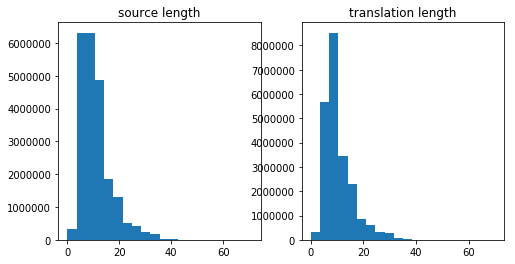

In [39]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20)

In [50]:
%env CUDA_VISIBLE_DEVICES=0
import tensorflow as tf
import keras.layers as L
from keras import backend as K
from utils import infer_length, infer_mask

env: CUDA_VISIBLE_DEVICES=0


In [55]:
import pickle
from utils import select_values_over_last_axis
import rupo.api

class AttentionLayer:
    def __init__(self, name, hid_size, activ=tf.tanh,):
        """ A layer that computes additive attention response and weights """
        self.name = name
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        with tf.variable_scope(name):
            # YOUR CODE - create layer variables
            #<YOUR CODE>
            self.linear_e = L.Dense(hid_size)
            self.linear_d = L.Dense(hid_size)
            self.linear_out = L.Dense(1)

    def __call__(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        with tf.variable_scope(self.name):
            
            # Compute logits
            #<...>
            logits_seq = self.linear_out(self.activ(self.linear_e(enc) + \
                                                    self.linear_d(dec)[:, tf.newaxis, :]))
            logits_seq = tf.squeeze(logits_seq, axis = -1)
            
            # Apply mask - if mask is 0, logits should be -inf or -1e9
            # You may need tf.where
            #<...>
            
            logits_seq = tf.where(inp_mask, logits_seq, tf.fill(tf.shape(logits_seq),
                                                                -np.inf))
            
            # Compute attention probabilities (softmax)
            probs = tf.nn.softmax(logits_seq) # <...>
            
            # Compute attention response using enc and probs
            attn = tf.reduce_sum(probs[..., tf.newaxis] * enc, axis = 1) # <...>
            
            return attn, probs
        
RHYME_PREFIX = 1
RHYME_WORD = 2
        
class AttentiveModel:
    def __init__(self, filename, name = None, inp_voc = None, out_voc = None,
                 emb_size = None, hid_size = None):
        
        self.vowels = {'а','е','ё','и','о','у','ы','э','ю','я'}
        self.consonants = {'б','в','г','д','ж','з','к','л','м',
                           'н','п','р','с','т','ф','х','ц','ч','ш','щ','ъ','ь'}
        
        self.rupo_engine = rupo.api.Engine(language = 'ru')
        rupo_data_root = '/srv/hd6/data/Poem2Poem/data/rupo/'
        self.rupo_engine.load(rupo_data_root + \
                              'stress_models/stress_ru_LSTM64_dropout0.2_acc99_wer8.h5',
                              rupo_data_root + 'dict/zaliznyak.txt')
        
        if filename is None:
            self.initialize(name, inp_voc, out_voc,
                            emb_size, hid_size) #, attn_size)
        else:
            self.load(filename)
    
    
    def initialize(self, name, inp_voc, out_voc,
                   emb_size, hid_size): #, attn_size):
        
        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc
        self.emb_size = emb_size
        self.hid_size = hid_size
        #self.attn_size = attn_size

        with tf.variable_scope(name):
            
            # YOUR CODE - define model layers
            
            # <...>
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc_lstm_fw_cell = tf.nn.rnn_cell.BasicLSTMCell(hid_size,
                                                                 forget_bias=1.0,
                                                                 state_is_tuple = False)
            self.enc_lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(hid_size,
                                                                 forget_bias=1.0,
                                                                 state_is_tuple = False)
            #self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.dense = L.Dense(hid_size)
            self.activ = tf.tanh
            self.logits = L.Dense(len(out_voc))
            
            self.attention = AttentionLayer(name = 'attention',
                                            #enc_size = None, # FIXME: Unused
                                            #dec_size = None, # FIXME: Unused
                                            #hid_size = attn_size)
                                            hid_size = 2 * self.hid_size)
            
            # END OF YOUR CODE
            
            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
            self.next_softmax = tf.nn.softmax(self.next_logits)

        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        
        # Call to 'K.get_session()' runs variable initializes for
        # all variables including ones initialized using
        # 'tf.global_variables_initializer()' (at least for Keras
        # 2.0.5) thus it have to be called once here or model weights
        # will be rewritten after training e.g. when 'get_weights' is
        # called.
        K.get_session()

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        # <YOUR CODE>
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_mask = infer_mask(inp, self.inp_voc.eos_ix, dtype = tf.bool)
        
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            #enc_seq, enc_last = tf.nn.dynamic_rnn(self.enc0,
            #                                      inp_emb,
            #                                      sequence_length = inp_lengths,
            #                                      dtype = inp_emb.dtype)
            ((enc_seq_fw,
              enc_seq_bw),
             (enc_last_fw,
              enc_last_bw)) = tf.nn.bidirectional_dynamic_rnn(self.enc_lstm_fw_cell,
                                                              self.enc_lstm_bw_cell,
                                                              inp_emb,
                                                              sequence_length = inp_lengths,
                                                              dtype = inp_emb.dtype)
        enc_seq = tf.concat((enc_seq_fw, enc_seq_bw), axis = -1)
        dec_start = self.dec_start(enc_last_fw)
        
        # apply attention layer from initial decoder hidden state
        #first_attn_probas = <...>
        _, first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        #first_state = [<...>, first_attn_probas]
        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch,n_tokens]
        """
        # Unpack your state: you will get tensors in the same order
        # that you've packed in encode
        #[<...>, prev_attn_probas] = prev_state
        [prev_dec, enc_seq, inp_mask, prev_attn_probas] = prev_state
        
        
        # Perform decoder step
        # * predict next attn response and attn probas given previous decoder state
        # * use prev token embedding and attn response to update decoder states
        # * (concatenate and feed into decoder cell)
        # * predict logits
        
        # <APPLY_ATTENTION>
        next_attn_response, next_attn_probas = self.attention(enc_seq, prev_dec, inp_mask)

        # <YOUR CODE>
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        dec_inputs = tf.concat([prev_emb, next_attn_response], axis = 1)
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(dec_inputs, prev_dec)
        output_logits = self.logits(self.activ(self.dense(new_dec_out)))
        #output_logits = self.logits(self.activ(new_dec_out))
        
        # Pack new state:
        # * replace previous decoder state with next one
        # * copy encoder sequence and mask from prev_state
        # * append new attention probas
        #next_state = [<...>, next_attn_probas]
        next_state = [new_dec_state, enc_seq, inp_mask, next_attn_probas]
        return next_state, output_logits

    
    def compute_logits(self, inp, out, **flags):
        
        batch_size = tf.shape(inp)[0]

        # Encode inp, get initial state
        first_state = self.encode(inp) # <YOUR CODE HERE>

        # initial logits: always predict BOS
        first_logits = tf.log(tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix),
                                         len(self.out_voc)) + 1e-30)

        # Decode step
        def step(prev_state, y_prev):
            # Given previous state, obtain next state and next token logits
            # <YOUR CODE>
            next_dec_state, next_logits = self.decode(prev_state, y_prev)
            return next_dec_state, next_logits # <...>

        # You can now use tf.scan to run step several times.
        # use tf.transpose(out) as elems (to process one time-step at a time)
        # docs: https://www.tensorflow.org/api_docs/python/tf/scan

        # <YOUR CODE>

        out = tf.scan(lambda a, y: step(a[0], y),
                      elems = tf.transpose(out)[:-1],
                      initializer = (first_state, first_logits))


        # FIXME remove?
        #sess.run(tf.initialize_all_variables())

        logits_seq = out[1] # <YOUR CODE>

        # prepend first_logits to logits_seq
        logits_seq = tf.concat((first_logits[tf.newaxis], logits_seq), axis = 0) #<...>

        # Make sure you convert logits_seq from
        # [time, batch, voc_size] to [batch, time, voc_size]
        logits_seq = tf.transpose(logits_seq, perm = [1, 0, 2]) #<...>

        return logits_seq

    def compute_loss(self, inp, out, **flags):
        
        mask = infer_mask(out, out_voc.eos_ix)    
        logits_seq = self.compute_logits(inp, out, **flags)

        # Compute loss as per instructions above
        # <YOUR CODE>

        prob_seq = tf.nn.softmax(logits_seq)
        out_one_hot = tf.one_hot(out, len(self.out_voc))

        prob_seq_masked = tf.boolean_mask(prob_seq, mask)
        out_one_hot_masked = tf.boolean_mask(out_one_hot, mask)
        prob_seq_out = tf.boolean_mask(prob_seq_masked, out_one_hot_masked)
        loss = tf.reduce_mean(-tf.log(prob_seq_out))

        return loss
    
    def translate_lines(self, inp_lines, max_len=100):
        """
        Translates a list of lines by greedily selecting most likely next token at each step
        :returns: a list of output lines, a sequence of model states at each step
        """
        state = sess.run(self.initial_state, {self.inp: self.inp_voc.to_matrix(inp_lines)})
        outputs = [[self.out_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = sess.run([self.next_state, self.next_logits],
                                     {**dict(zip(self.prev_state, state)),
                                      self.prev_tokens: [out_i[-1] for out_i in outputs]})
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.out_voc.eos_ix
        return self.out_voc.to_lines(outputs), all_states
    
    def get_prefix(self, line):
        assert type(line) == str
        
        res = ''
        
        VOWEL_ID = 1
        CONS_ID = 2
        prev_ch_id = 0
        
        for ch in line.lower():
            ch_id = 0
            if ch in self.vowels:
                ch_id = VOWEL_ID
            elif ch in self.consonants:
                ch_id = CONS_ID
            
            if ch_id:
                res += ch
                
            if prev_ch_id == 0:
                prev_ch_id = ch_id
            elif prev_ch_id != ch_id:
                break
                
        return res

    def has_word(self, line):
        assert type(line) == str
        
        prev_in_word = False
        for ch in line.lower():
            in_word = ch in self.vowels or ch in self.consonants
            if prev_in_word and not in_word:
                return True
            prev_in_word = in_word
        return False

    def get_word(self, line):
        assert type(line) == str
        
        res = ''
        prev_in_word = False
        for ch in line.lower():
            in_word = ch in self.vowels or ch in self.consonants
            if in_word:
                res += ch
            elif prev_in_word:
                return res
            prev_in_word = in_word
            
        return res
    
    def translate_line_with_rhyme(self,
                                  inp_line,
                                  rhyme_line,
                                  rhyme_type,
                                  max_len,
                                  max_rhyme_retry_count):
        
        def tokens_to_line(toks):
            return ''.join(self.out_voc.to_lines([toks])[0].replace('@@ ', ''))
        
        check_rhyme = rhyme_line is not None
        
        if check_rhyme:
            if rhyme_type == RHYME_PREFIX:
                rhyme_prefix = self.get_prefix(rhyme_line)
                print(' rhyme prefix: "{}"'.format(''.join(reversed(rhyme_prefix))))
            elif rhyme_type == RHYME_WORD:
                rhyme_word = ''.join(reversed(self.get_word(rhyme_line)))
                print(' rhyme word: "{}"'.format(rhyme_word))
            else:
                assert False
        
        for rhyme_retry_idx in range(max_rhyme_retry_count):
            
            rhyme_can_retry = rhyme_retry_idx < max_rhyme_retry_count - 1
            rhyme_state = None if check_rhyme else True
            
            state = sess.run(self.initial_state, {self.inp: self.inp_voc.to_matrix([inp_line])})
            output = [self.out_voc.bos_ix]

            for t in range(max_len):
                state, logits, softmax = sess.run([self.next_state,
                                                   self.next_logits,
                                                   self.next_softmax],
                                                  {**dict(zip(self.prev_state, state)),
                                                   self.prev_tokens: [output[-1]]})
                
                probs = softmax[0] ** (1. / 0.5)
                probs /= probs.sum()
                # sample from softmax with temperature
                next_token = np.random.choice(len(probs), p = probs)
                output.append(next_token)
                
                eos_token = next_token == self.out_voc.eos_ix
                
                if rhyme_can_retry and rhyme_state is None:
                    
                    line = tokens_to_line(output)
                    
                    if eos_token or self.has_word(line):
                        
                        if rhyme_type == RHYME_PREFIX:
                            
                            prefix = self.get_prefix(line)
                            print('  line prefix: "{}"'.format(''.join(reversed(prefix))))
                            
                            pref_len = min(len(rhyme_prefix), len(prefix))
                            rhyme_state = prefix[:pref_len] == rhyme_prefix[:pref_len]
                            
                        elif rhyme_type == RHYME_WORD:
                            
                            word = ''.join(reversed(self.get_word(line)))
                            print('  line word: "{}"'.format(word))
                            
                            rhyme_state = self.rupo_engine.is_rhyme(rhyme_word, word)
                            
                        else:
                            assert False

                            
                        
                        if not rhyme_state: # Rhyme is bad and can retry
                            break
                            
                        print('  rhyme found!')
                        
                if eos_token:
                    break
            
            if rhyme_state: # Rhyme is OK
                break
        
        return tokens_to_line(output)
    
    
    def translate_lines_with_rhyme(self,
                                   inp_lines,
                                   rhyme_type = RHYME_WORD,
                                   max_len = 100,
                                   max_rhyme_retry_count = 20):

        
        translated = []
        for i in range(len(inp_lines)):
            
            inp_line = inp_lines[i]
            rhyme_line = translated[-1] if i % 2 == 1 else None
            
            
            line = self.translate_line_with_rhyme(inp_lines[i],
                                                  rhyme_line,
                                                  rhyme_type,
                                                  max_len,
                                                  max_rhyme_retry_count)

            translated.append(line)
            
        return translated

    
    def dump(self, filename):
        
        values = {'name': self.name,
                  'inp_voc': self.inp_voc,
                  'out_voc': self.out_voc,
                  'emb_size': self.emb_size,
                  'hid_size': self.hid_size,
                  #'attn_size': self.attn_size,
                  'emb_inp_weights': self.emb_inp.get_weights(),
                  'emb_out_weights': self.emb_out.get_weights(),
                  #'enc0_weights': self.enc0.get_weights(),
                  'enc_lstm_fw_cell_weights': self.enc_lstm_fw_cell.get_weights(),
                  'enc_lstm_bw_cell_weights': self.enc_lstm_bw_cell.get_weights(),
                  'dec0_weights': self.dec0.get_weights(),
                  'dec_start_weights': self.dec_start.get_weights(),
                  'dense_weights': self.dense.get_weights(),
                  'logits_weights': self.logits.get_weights(),
                  'attn__linear_e_weights': self.attention.linear_e.get_weights(),
                  'attn__linear_d_weights': self.attention.linear_d.get_weights(),
                  'attn__linear_out_weights': self.attention.linear_out.get_weights()}
        pickle.dump(values, open(filename, 'wb'))
    
    def load(self, filename):
        with open(filename, 'rb') as f:
            values = pickle.load(f)
        self.initialize(values['name'], values['inp_voc'], values['out_voc'],
                        values['emb_size'], values['hid_size']) #, values['attn_size'])
        self.emb_inp.set_weights(values['emb_inp_weights'])
        self.emb_out.set_weights(values['emb_out_weights'])
        #self.enc0.set_weights(values['enc0_weights'])
        self.enc_lstm_fw_cell.set_weights(values['enc_lstm_fw_cell_weights'])
        self.enc_lstm_bw_cell.set_weights(values['enc_lstm_bw_cell_weights'])
        self.dec0.set_weights(values['dec0_weights'])
        self.dec_start.set_weights(values['dec_start_weights'])
        self.dense.set_weights(values['dense_weights'])
        self.logits.set_weights(values['logits_weights'])
        self.attention.linear_e.set_weights(values['attn__linear_e_weights'])
        self.attention.linear_d.set_weights(values['attn__linear_d_weights'])
        self.attention.linear_out.set_weights(values['attn__linear_out_weights'])
        

In [56]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations
        given inp and reference out """
    translations, _ = model.translate_lines(inp_lines, **flags)
    # Note: if you experience out-of-memory error,
    # split input lines into batches and translate separately
    return corpus_bleu([[ref] for ref in out_lines], translations) * 100

def compute_bleu_large(model, inp_lines, out_lines):
    batch_size = 256
    result = 0.0
    for i in range(0, inp_lines.shape[0], batch_size):
        current_bleu = compute_bleu(model,
                                    inp_lines[i:i+batch_size],
                                    out_lines[i:i+batch_size])
        current_bleu *= min(i + batch_size, inp_lines.shape[0]) - i
        result += current_bleu
    result /= inp_lines.shape[0]
    return result

In [53]:
def get_reversed(line):
    return ''.join(reversed(line))

In [57]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel(None,
                       'model_translator_attn_reversed_amalgama_subtitles_09_03_2019',
                       inp_voc,
                       out_voc,
                       emb_size=128,
                       hid_size=256)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead


In [58]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = model.compute_loss(inp, out)
train_step = tf.train.AdamOptimizer().minimize(loss)
K.get_session() # To not reset optimizer

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [59]:
import datetime
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 32
dev_batch_size = 128

def train_model(train_inp, train_out, dev_inp, dev_out, iters):

    start = datetime.datetime.now()

    for _ in trange(iters):
    #for _ in range(iters):
        step = len(metrics['train_loss']) + 1
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        feed_dict = {
            inp: inp_voc.to_matrix(train_inp[batch_ix]),
            out: out_voc.to_matrix(train_out[batch_ix]),
        }

        loss_t, _ = sess.run([loss, train_step], feed_dict)
        metrics['train_loss'].append((step, loss_t))

        if step % 100 == 0:
            batch_dev_ix = np.random.randint(len(dev_inp), size=dev_batch_size)
            metrics['dev_bleu'].append((step, compute_bleu(model,
                                                           dev_inp[batch_dev_ix],
                                                           dev_out[batch_dev_ix])))

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1],
                  flush=True)
        if step % 10000 == 0:
            model.dump('{}.pkl'.format(model.name))
    end = datetime.datetime.now()
    print('Execution time: {}'.format(end - start))


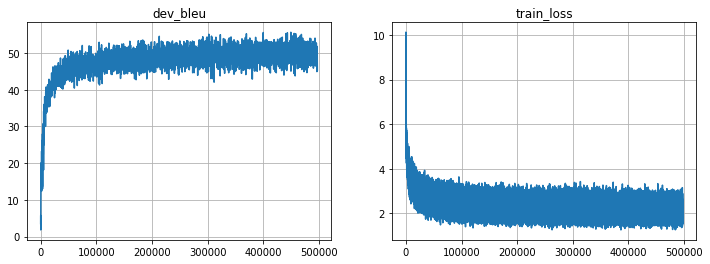

Mean loss=2.313


 90%|█████████ | 497232/550001 [102:03:07<10:49:49,  1.35it/s]

In [ ]:
train_model(train_inp,
            train_out,
            dev_inp,
            dev_out,
            550001)

In [ ]:
%%time
dev_bleu = compute_bleu_large(model, dev_inp, dev_out)
print('dev_bleu', dev_bleu)

Let us dump current model

And let us fine-tune our model with only Amalgama

In [ ]:
train_model(amalgama_train_inp,
            amalgama_train_out,
            amalgama_dev_inp,
            amalgama_dev_out,
            150001)

In [ ]:
%%time
amalgama_dev_bleu = compute_bleu_large(model, amalgama_dev_inp, amalgama_dev_out)
print('amalgama_dev_bleu', amalgama_dev_bleu)

In [ ]:
import random

random_dev_song = dev_songs[random.randint(1, len(dev_songs) - 1)][0]
source = [pair[0] for pair in random_dev_song]
target = [pair[1] for pair in random_dev_song]
predicted = model_loaded.translate_lines(source)[0]
for i in range(len(source)):
    print('{}|{}|{}'.format(get_reversed(source[i]),
                            get_reversed(target[i]),
                            get_reversed(predicted[i])))
print('-----------------------')
print('\n'.join(map(get_reversed, source)))
print('-----------------------')
print('\n'.join(map(get_reversed, target)))
print('-----------------------')
print('\n'.join(map(get_reversed, predicted)))
      